In [1]:
%cd ../

/home/tadenoud/Git/simple-faster-rcnn-pytorch


In [2]:
SAVE_FEATURES = False

In [14]:
RANDOM_SEED = 42
SUBSET_SAMPLE_DATA_PERCENTAGE = 0.1
MIN_IOU_REQUIRED = 0.7  # The minimum IOU required to be a good detection (ie higher is more strict)
NUM_PROPOSALS = 300
CHECKPOINT_DIR = './idd_fn_detection'

%load_ext autoreload
%autoreload 2

import os
import torch as t
from model import FasterRCNNVGG16
from trainer import FasterRCNNTrainer
import numpy as np
import pickle
import h5py
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

from data.util import  read_image
from utils.vis_tool import vis_bbox
from utils import array_tool as at
from utils.config import opt
from utils.idd_utils import get_annotations
from model.utils.bbox_tools import bbox_iou

from data.dataset import Dataset, TestDataset, KittiDataset
from torch.utils.data import DataLoader
from utils.vis_tool import vis_bbox, vis_image
from utils.idd_utils import IndiaDrivingDataset
from ood_metrics import auroc, plot_roc, calc_metrics
from sklearn import svm
import pickle
import itertools
import torch
from model.faster_rcnn import nograd
from data.dataset import preprocess
from utils.mahalanobis import Mahal_Dist


import warnings
warnings.filterwarnings(action='once')

np.random.seed(RANDOM_SEED)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
%matplotlib inline

In [16]:
fg_detections = 13115
bg_detections = 292551

data_portion = fg_detections / bg_detections

In [17]:
if SAVE_FEATURES:
    opt.voc_data_dir = "./datasets/kitti_2d/VOC2012/"
    idd_data_dir = "./datasets/idd_detection/"

    # Subsample full dataset
    kitti_train_dataset = KittiDataset(opt, split='train')
    kitti_val_dataset = KittiDataset(opt, split='val')
    idd_val_dataset = IndiaDrivingDataset(idd_data_dir, split='val', keep_labels=[0])

    kitti_train_samples = round(len(kitti_train_dataset) * data_portion)
    kitti_val_samples = round(len(kitti_val_dataset) * data_portion)
    idd_val_samples = round(len(idd_val_dataset) * data_portion)

    KITTI_TRAIN_TO_USE = np.random.choice(kitti_train_samples, kitti_train_samples, replace=False)
    KITTI_VAL_TO_USE = np.random.choice(kitti_val_samples, kitti_val_samples, replace=False)
    IDD_VAL_TO_USE = np.random.choice(idd_val_samples, idd_val_samples, replace=False)

    kitti_train_dataset = torch.utils.data.Subset(kitti_train_dataset, KITTI_TRAIN_TO_USE)
    kitti_val_dataset = torch.utils.data.Subset(kitti_val_dataset, KITTI_VAL_TO_USE)
    idd_val_dataset = torch.utils.data.Subset(idd_val_dataset, IDD_VAL_TO_USE)


    # Subset Datasets
    subset_kitti_train_samples = round(kitti_train_samples * SUBSET_SAMPLE_DATA_PERCENTAGE)
    subset_kitti_val_samples = round(kitti_val_samples * SUBSET_SAMPLE_DATA_PERCENTAGE)
    subset_idd_val_samples = round(idd_val_samples * SUBSET_SAMPLE_DATA_PERCENTAGE)

    SUBSET_KITTI_TRAIN_TO_USE = np.random.choice(subset_kitti_train_samples, subset_kitti_train_samples, replace=False)
    SUBSET_KITTI_VAL_TO_USE = np.random.choice(subset_kitti_val_samples, subset_kitti_val_samples, replace=False)
    SUBSET_IDD_VAL_TO_USE = np.random.choice(subset_idd_val_samples, subset_idd_val_samples, replace=False)

    subset_kitti_train_dataset = torch.utils.data.Subset(kitti_train_dataset, SUBSET_KITTI_TRAIN_TO_USE)
    subset_kitti_val_dataset = torch.utils.data.Subset(kitti_val_dataset, SUBSET_KITTI_VAL_TO_USE)
    subset_idd_val_dataset = torch.utils.data.Subset(idd_val_dataset, SUBSET_IDD_VAL_TO_USE)

# Extract classifier features

In [18]:
string_dt = h5py.string_dtype(encoding='utf-8')
feature_layer_sizes = (512, 4096, 4096)

In [19]:
def extract_kitti_features(dataset, model, save_file, perturbation=0, temperature=1):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    _extract_features("kitti", dataset, model, save_file, perturbation, temperature)
                
                
def extract_idd_features(dataset, model, save_file, perturbation=0, temperature=1):
    """
    Given a IDD dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    _extract_features("idd", dataset, model, save_file, perturbation, temperature)
                

def show_max_ious_dist(data_file):
    """
    Given a data file generated by one of the feature_extractor functions, show the distribution 
    of IOUs with the gt data.
    """
    total_false_negatives = 0
    total_false_positives = 0
    total_true_positives = 0
    total_true_negatives = 0
    
    all_max_ious = np.array([])
    all_labels = np.array([])

    with h5py.File(data_file, "r") as f:
        dset_length = len(f)
        for i in range(dset_length):
            d = f[str(i)]
            pred_labels = d["pred_labels"][()]
            pred_label_corrects = d["pred_label_correct"][()]
            max_ious = d["pred_max_ious"][()]

            false_positives = ([lab >= 0 and \
                                (miou < MIN_IOU_REQUIRED or not corr) \
                                for miou, lab, corr in zip(max_ious, pred_labels, pred_label_corrects)])
            
            false_negatives = ([lab < 0 and \
                                (miou >= MIN_IOU_REQUIRED or not corr) \
                                for miou, lab, corr in zip(max_ious, pred_labels, pred_label_corrects)])

            true_positives = ([lab >= 0 and \
                               (miou >= MIN_IOU_REQUIRED and corr) \
                                for miou, lab, corr in zip(max_ious, pred_labels, pred_label_corrects)])
            
            true_negatives = ([lab < 0 and \
                               (miou < MIN_IOU_REQUIRED and corr) \
                               for miou, lab, corr in zip(max_ious, pred_labels, pred_label_corrects)])

            total_false_positives += sum(false_positives)
            total_false_negatives += sum(false_negatives)
            total_true_positives += sum(true_positives)
            total_true_negatives += sum(true_negatives)

            all_max_ious = np.concatenate((all_max_ious, max_ious), axis=0)
            all_labels = np.concatenate((all_labels, pred_labels), axis=0)
            
    plt.hist(all_max_ious[all_labels>=0], bins=50)
    plt.title("Predicted FG objects IOUs")
    plt.ylabel("Count")
    plt.xlabel("Max IOUS")
    plt.show()
    
    plt.hist(all_max_ious[all_labels<0], bins=50)
    plt.title("Predicted BG objects IOUs")
    plt.ylabel("Count")
    plt.xlabel("Max IOUS")
    plt.show()

    total_fg_detections = len(all_max_ious[all_labels>=0])
    total_bg_detections = len(all_max_ious[all_labels<0])
    
    print("FPs: %d" % total_false_positives)
    print("FNs: %d" % total_false_negatives)
    print("TPs: %d" % total_true_positives)
    print("TNs: %d" % total_true_negatives)
    print()
    print("Total FG detections: %d" % (total_fg_detections))
    print("Total BG detections: %d" % (total_bg_detections))
    print()
    print("FP/TP+FP: %f%%" % (total_false_positives/total_fg_detections * 100))
    print("FN/TN+FN: %f%%" % (total_false_negatives/total_bg_detections * 100))
    

def read_features(save_file, feature_idx, start=0, end=None, leave=True):
    """
    Read the features from the extracted HD5F feature file and return them as a numpy array
    along with a label array y describing if the features correspond to a high IOU gt box with
    the same classification as the prediction.
    
    Label array is 1 for a false positive and 0 for a true positive
    """
    with h5py.File(save_file, "r") as f:       
        X = None
        y = np.empty((0,))
        
        if end is None or end > len(f):
            end = len(f)
        
        for i in trange(start, end, leave=leave):
            d = f[str(i)]
            features = d["pred_features_%d" % feature_idx][()]
            
            # Select only the negative preds
            label_is_fg = d["pred_labels"][()] >= 0
            mask = np.logical_not(label_is_fg)
            
            if X is None:
                # Initialize X array to correct size
                X = np.copy(features[mask])
            else:
                X = np.concatenate((X, features[mask]), axis=0)
            
            iou_is_low_enough = d["pred_max_ious"][()][mask] < MIN_IOU_REQUIRED
            classification_is_correct = d["pred_label_correct"][()][mask] == 1

            # Determine if each bbox is a high accuracy, correct class case
            label = iou_is_low_enough & classification_is_correct
            y = np.concatenate((y, label.astype(np.int)), axis=0)
            
    return X, 1 - y


def read_scores(save_file, start=0, end=None, leave=True):
    """
    Read the max_softmax scores from the extracted HD5F feature file and return them as a numpy array
    along with a label array y describing if the features correspond to a high IOU gt box with
    the same classification as the prediction.
    
    Label array is 1 for a false positive and 0 for a true positive
    """
    with h5py.File(save_file, "r") as f:       
        X = None
        y = np.empty((0,))
        
        if end is None or end > len(f):
            end = len(f)
            
        for i in trange(start, end, leave=leave):
            d = f[str(i)]
            features = d["pred_scores"][()]
            
            # Select only the negative preds
            label_is_fg = d["pred_labels"][()] >= 0
            mask = np.logical_not(label_is_fg)
            
            if X is None:
                # Initialize X array to correct size
                X = np.copy(features[mask])
            else:
                X = np.concatenate((X, features[mask]), axis=0)
            
            iou_is_low_enough = d["pred_max_ious"][()][mask] < MIN_IOU_REQUIRED
            classification_is_correct = d["pred_label_correct"][()][mask] == 1

            # Determine if each bbox is a high accuracy, correct class case
            label = iou_is_low_enough & classification_is_correct
            y = np.concatenate((y, label.astype(np.int)), axis=0)
            
    return X, 1 - y


def chunked_calc(read_func, read_func_args, save_file, novelty_func, chunk_size):
    scores = []
    labels = []
    
    l = 0
    with h5py.File(save_file, 'r') as f:
        l = len(f)
     
    for i in range(0, l, chunk_size):
        X, y = read_func(*read_func_args, start=i, end=i+chunk_size, leave=False)
        scores.append(novelty_func(X))
        labels.append(y)
        
    return np.concatenate(scores, axis=0), np.concatenate(labels, axis=0)

In [20]:
def save_novelty_scores_labels(scores, labels, filename):
    with h5py.File(filename, 'w') as f:
        f.create_dataset("scores", data=scores)
        f.create_dataset("labels", data=labels)

def load_novelty_scores_labels(filename):
    scores, labels = [],[]
    with h5py.File(filename, 'r') as f:
        scores = f["scores"][()]
        labels = f["labels"][()]
    return scores, labels


# Extract classifier features

#### Kitti Train

In [10]:
%reset -f array

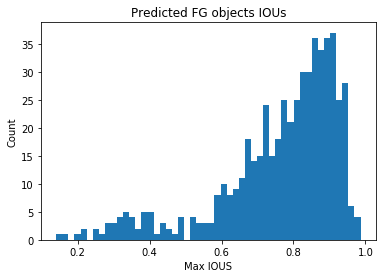

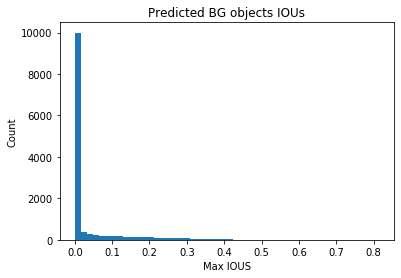

FPs: 142
FNs: 2407
TPs: 408
TNs: 10667

Total FG detections: 550
Total BG detections: 13074

FP/TP+FP: 25.818182%
FN/TN+FN: 18.410586%


In [11]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train.hdf5")
show_max_ious_dist(save_path)

#### Kitti Val

In [12]:
%reset -f array

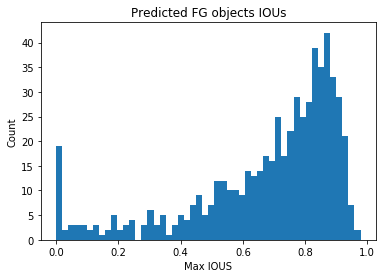

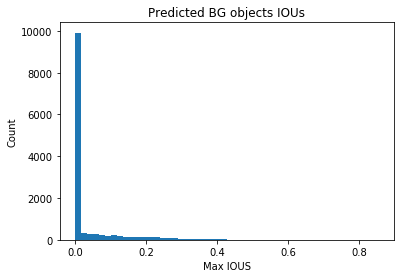

FPs: 240
FNs: 2724
TPs: 351
TNs: 10292

Total FG detections: 591
Total BG detections: 13016

FP/TP+FP: 40.609137%
FN/TN+FN: 20.928089%


In [13]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")
show_max_ious_dist(save_path)

#### IDD Val

In [14]:
%reset -f array

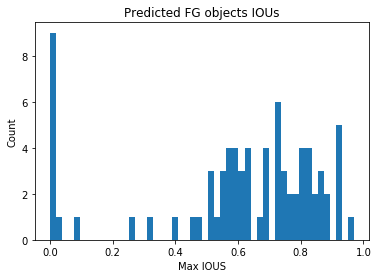

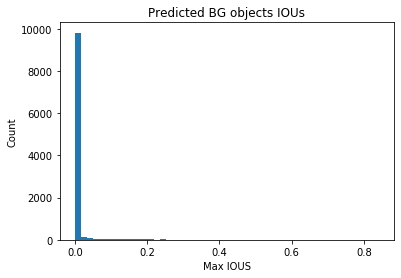

FPs: 43
FNs: 1151
TPs: 34
TNs: 9278

Total FG detections: 77
Total BG detections: 10429

FP/TP+FP: 55.844156%
FN/TN+FN: 11.036533%


In [15]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")
show_max_ious_dist(save_path)

# Max Softmax

In [17]:
if SAVE_FEATURES:
    save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")
    kitti_val_X, kitti_val_y = read_scores(save_path)

    kitti_val_novelty_scores = -kitti_val_X
    save_novelty_scores_labels(kitti_val_novelty_scores, kitti_val_y, os.path.join(CHECKPOINT_DIR,"scores_labels_kitti_val_softmax"))
    
    save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")
    idd_val_X, idd_val_y = read_scores(save_path)

    idd_val_novelty_scores = -idd_val_X
    save_novelty_scores_labels(idd_val_novelty_scores, idd_val_y, os.path.join(CHECKPOINT_DIR,"scores_labels_idd_val_softmax"))

## One-Class SVM on Kitti features (Conv-512 layer)

In [18]:
# Train a one-class SVM networks with those features
if SAVE_FEATURES:
    ONE_CLASS_SAVE_PATH = os.path.join(CHECKPOINT_DIR, "kitti-conv-512-one-class.pickle")
    with open(ONE_CLASS_SAVE_PATH, 'rb') as f:
        clf = pickle.load(f)

    %reset -f array

    save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")

    kitti_val_novelty_scores, kitti_val_y = chunked_calc(
        read_features, [save_path, 0], save_path, clf.decision_function, 1000)

    save_novelty_scores_labels(-kitti_val_novelty_scores, kitti_val_y, os.path.join(CHECKPOINT_DIR,"scores_labels_kitti_val_svm_conv"))

    %reset -f array

    save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")

    idd_val_novelty_scores, idd_val_y = chunked_calc(
        read_features, [save_path, 0], save_path, clf.decision_function, 1000)

    save_novelty_scores_labels(-idd_val_novelty_scores, idd_val_y, os.path.join(CHECKPOINT_DIR,"scores_labels_idd_val_svm_conv"))

## One-Class SVM on Kitti features (FC-4096 (#1) layer) 

In [19]:
if SAVE_FEATURES:
    ONE_CLASS_SAVE_PATH = os.path.join(CHECKPOINT_DIR, "kitti-fc-4096-1-one-class.pickle")
    with open(ONE_CLASS_SAVE_PATH, 'rb') as f:
        clf = pickle.load(f)

    %reset -f array

    save_path = os.path.join(CHECKPOINT_DIR, os.path.join(CHECKPOINT_DIR,"kitti_cars_detections_val.hdf5"))

    kitti_val_novelty_scores, kitti_val_y = chunked_calc(
        read_features, [save_path, 1], save_path, clf.decision_function, 1000)

    save_novelty_scores_labels(-kitti_val_novelty_scores, kitti_val_y, "scores_labels_kitti_val_svm_fc")

    %reset -f array

    save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")

    idd_val_novelty_scores, idd_val_y = chunked_calc(
        read_features, [save_path, 1], save_path, clf.decision_function, 1000)

    save_novelty_scores_labels(-idd_val_novelty_scores, idd_val_y, os.path.join(CHECKPOINT_DIR,"scores_labels_idd_val_svm_fc"))

# Mahalanobis

In [20]:
if SAVE_FEATURES:
    %reset -f array

    mahal_model_name = os.path.join(CHECKPOINT_DIR, "kitti-cars-fc-4096-4-mahalanobis.h5")
    md = Mahal_Dist.load(mahal_model_name)

    #### Kitti val

    %reset -f array

    save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")

    kitti_val_novelty_scores, kitti_val_y = chunked_calc(
        read_features, [save_path, 4], save_path, md, 1000)

    save_novelty_scores_labels(kitti_val_novelty_scores, kitti_val_y, os.path.join(CHECKPOINT_DIR,"scores_labels_kitti_val_mahal"))

    #### IDD val

    %reset -f array

    save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")

    idd_val_novelty_scores, idd_val_y = chunked_calc(
        read_features, [save_path, 4], save_path, md, 1000)

    save_novelty_scores_labels(idd_val_novelty_scores, idd_val_y, os.path.join(CHECKPOINT_DIR,"scores_labels_idd_val_mahal"))

## ODIN

In [21]:
if SAVE_FEATURES:
    eps, temp = 0.002400, 1000

    %reset -f array

    save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_pert_%f_temp_%d.hdf5" % (eps, temp))

    print("ODIN Kitti Val e=%f, T=%d" % (eps, temp))

    kitti_val_novelty_scores, kitti_val_y = chunked_calc(
        read_scores, [save_path], save_path, lambda x: -x, 1000)

    save_novelty_scores_labels(kitti_val_novelty_scores, kitti_val_y, os.path.join(CHECKPOINT_DIR,"scores_labels_kitti_val_odin"))

    #### IDD val

    %reset -f array

    save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_pert_%f_temp_%d.hdf5" % (eps, temp))

    idd_val_novelty_scores, idd_val_y = chunked_calc(
        read_scores, [save_path], save_path, lambda x: -x, 1000)

    save_novelty_scores_labels(idd_val_novelty_scores, idd_val_y, os.path.join(CHECKPOINT_DIR,"scores_labels_idd_val_odin"))

ODIN Kitti Val e=0.002400, T=1000


## Entropy

In [22]:
import mc_uncertainty as mcu

if SAVE_FEATURES:
    NUM_MC_PASSES = 10

    def read_mc_scores(save_file, start=0, end=None, leave=True):
        """
        Read the max_softmax scores from the extracted HD5F feature file and return them as a numpy array
        along with a label array y describing if the features correspond to a high IOU gt box with
        the same classification as the prediction.

        Label array is 1 for a true negative and 0 for a false negative
        """
        with h5py.File(save_file, "r") as f:       
            X = None
            y = np.empty((0,))

            if end is None or end > len(f):
                end = len(f)

            for i in trange(start, end, leave=leave):
                d = f[str(i)]
                features = d["mc_scores"][()]

                # Select only the negative preds
                label_is_fg = d["pred_labels"][()] >= 0
                mask = np.logical_not(label_is_fg)

                if X is None:
                    # Initialize X array to correct size
                    X = np.copy(features[:,mask])
                else:
                    X = np.concatenate((X, features[:,mask]), axis=1)

                iou_is_low_enough = d["pred_max_ious"][()][mask] < MIN_IOU_REQUIRED
                classification_is_correct = d["pred_label_correct"][()][mask] == 1

                # Determine if each bbox is a high accuracy, correct class case
                label = iou_is_low_enough & classification_is_correct
                y = np.concatenate((y, label.astype(np.int)), axis=0)

        return X, 1 - y

    #### Kitti Val

    save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_mc_dropout.hdf5")

    kitti_val_novelty_scores, kitti_val_y = chunked_calc(
        read_mc_scores, [save_path], save_path, mcu.predicted_entropy, 1000)

    save_novelty_scores_labels(kitti_val_novelty_scores, kitti_val_y, os.path.join(CHECKPOINT_DIR,"scores_labels_kitti_val_entropy"))

    #### IDD Val

    save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_mc_dropout.hdf5")

    idd_val_novelty_scores, idd_val_y = chunked_calc(
        read_mc_scores, [save_path], save_path, mcu.predicted_entropy, 1000)

    save_novelty_scores_labels(idd_val_novelty_scores, idd_val_y, os.path.join(CHECKPOINT_DIR,"scores_labels_idd_val_entropy"))

## Mutual Information

In [23]:
if SAVE_FEATURES:
    #### Kitti Val

    save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_mc_dropout.hdf5")

    kitti_val_novelty_scores, kitti_val_y = chunked_calc(
        read_mc_scores, [save_path], save_path, mcu.mutual_information, 1000)

    save_novelty_scores_labels(kitti_val_novelty_scores, kitti_val_y, os.path.join(CHECKPOINT_DIR,"scores_labels_kitti_val_mi"))

    #### IDD Val

    save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_mc_dropout.hdf5")

    idd_val_novelty_scores, idd_val_y = chunked_calc(
        read_mc_scores, [save_path], save_path, mcu.mutual_information, 1000)

    save_novelty_scores_labels(idd_val_novelty_scores, idd_val_y, os.path.join(CHECKPOINT_DIR,"scores_labels_idd_val_mi"))

# Vahdats Extended Feature Extractor Set

In [45]:
if SAVE_FEATURES:
    # Train a one-class SVM networks with those features
    GT_FEATURES_FILE = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train_extended_gt.hdf5")
    SUBSET_KITTI_VAL_FEATURES_FILE = os.path.join(CHECKPOINT_DIR, "subset_kitti_cars_detections_val_extended.hdf5")
    KITTI_TRAIN_FEATURES_FILE = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train_extended.hdf5")
    KITTI_VAL_FEATURES_FILE = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_extended.hdf5")
    IDD_VAL_FEATURES_FILE = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_extended.hdf5")
    NUM_EXTENDED_FEATURES = 30

    def read_extended_features(file, feature_idx):
        X = None
        y = np.empty((0,))

        with h5py.File(file, "r") as f:
            for im in tqdm(f.keys(), total=len(f), leave=False):
                im = f[im]            

                # Select only the negative preds
                label_is_fg = im['pred']["pred_labels"][()] >= 0
                mask = np.logical_not(label_is_fg)

                iou_is_low_enough = im['pred']["pred_max_ious"][()][mask] < MIN_IOU_REQUIRED
                classification_is_correct = im['pred']["pred_label_correct"][()][mask] == 1

                # Determine if each bbox is a high accuracy, correct class case
                label = iou_is_low_enough & classification_is_correct
                y = np.concatenate((y, label.astype(np.int)), axis=0)

                # Get the required features
                for j in np.array(sorted(im['bboxes'].keys()))[mask]:
                    bbox = im['bboxes'][j]
                    feats = bbox["extended_feat_%d" % feature_idx]

                    if X is None:
                        X = np.expand_dims(feats, axis=0)
                    else:
                        X = np.concatenate((X, np.expand_dims(feats, axis=0)), axis=0)

        return X, 1 - y

    NUS = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
    # GAMMAS = ['auto', 'scale']
    GAMMAS = ['auto']
    # KERNELS = ['rbf', 'linear']
    KERNELS = ['rbf']

    train_args = list(itertools.product(NUS, GAMMAS, KERNELS))

    ### Determine best params/OODL

    with open(os.path.join(CHECKPOINT_DIR, 'one_class_models/subset_kitti_val_results.pickle'), 'rb') as f:
        kitti_val_results = pickle.load(f)

    best_params = np.argmin([k['detection_error'] for k in kitti_val_results])

    oodl, (nu, gamma, kernel) = list(itertools.product(list(range(NUM_EXTENDED_FEATURES)), train_args))[best_params]
    print(oodl, nu, gamma, kernel)
    
    # Load the best classifier
    save_path = os.path.join(CHECKPOINT_DIR, "one_class_models/kitti-one-class-extended-feat%d-nu%.4f-gamma%s-kernel%s.pickle" % (oodl, nu, gamma, kernel))
    with open(save_path, 'rb') as f:
        clf = pickle.load(f)

    ### Kitti Val

    kitti_val_X, kitti_val_y = read_extended_features(KITTI_VAL_FEATURES_FILE, oodl)

    # Calculate performance metrics
    kitti_val_novelty_scores = clf.decision_function(kitti_val_X)
    save_novelty_scores_labels(kitti_val_novelty_scores, kitti_val_y, os.path.join(CHECKPOINT_DIR,"scores_labels_kitti_val_svm_vahdat"))

    ### IDD VAL

    idd_val_X, idd_val_y = read_extended_features(IDD_VAL_FEATURES_FILE, oodl)

    # Calculate performance metrics
    idd_val_novelty_scores = clf.decision_function(idd_val_X)
    save_novelty_scores_labels(idd_val_novelty_scores, idd_val_y, os.path.join(CHECKPOINT_DIR,"scores_labels_idd_val_svm_vahdat"))

23 0.0001 auto rbf


KeyboardInterrupt: 

## Mahalanobis with input perturbation

In [35]:
if SAVE_FEATURES:
    %reset -f array

    # for T 1, 2, 5, 10,20, 50, 100, 200, 500, 1000; and for perturbation magnitude
    # ε we choose from 21 evenly spaced numbers starting from 0
    # and ending at 0.004.

    # temperatures = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000])
    temperatures = np.array([1000])

    epsilons = np.linspace(0, 0.004, 21)
    # epsilons = np.array([0.0034])

    odin_params = list(itertools.product(epsilons, temperatures))

    results2 = []
    for eps, temp in tqdm(odin_params, total=len(odin_params)):
        # Get the data
        save_path = os.path.join(CHECKPOINT_DIR, "subset_kitti_cars_detections_val_pert_%f_temp_%d.hdf5" % (eps, temp))
        kitti_val_X, kitti_val_y = read_features(save_path, 4)

        # Load the model
        mahal_model_name = os.path.join(CHECKPOINT_DIR, "kitti-cars-fc-4096-4-mahalanobis_pert_%f_temp_%d.pickle" % (eps, temp))
        md = Mahal_Dist.load(mahal_model_name)

        kitti_val_novelty_scores = md(kitti_val_X)
        results2.append(calc_metrics(kitti_val_novelty_scores, kitti_val_y))

    # Pick the best eps and temp

    idx = np.argmin(x['fpr_at_95_tpr'] for x in results2[1:])
    eps, temp = odin_params[1:][idx]
    print("e:", eps, "T:", temp)

    # Load the model
    mahal_model_name = os.path.join(CHECKPOINT_DIR, "kitti-cars-fc-4096-4-mahalanobis_pert_%f_temp_%d.pickle" % (eps, temp))
    md = Mahal_Dist.load(mahal_model_name)

    #### Kitti val

    %reset -f array

    save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")

    kitti_val_novelty_scores, kitti_val_y = chunked_calc(
        read_features, [save_path, 4], save_path, md, 1000)

    save_novelty_scores_labels(kitti_val_novelty_scores, kitti_val_y, os.path.join(CHECKPOINT_DIR,"scores_labels_kitti_val_mahal_p"))

    #### IDD val

    %reset -f array

    save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")

    idd_val_novelty_scores, idd_val_y = chunked_calc(
        read_features, [save_path, 4], save_path, md, 1000)

    save_novelty_scores_labels(idd_val_novelty_scores, idd_val_y, os.path.join(CHECKPOINT_DIR,"scores_labels_idd_val_mahal_p"))



e: 0.0002 T: 1000


# Load Features and Coverage Risk Values

# Draw the Chart

In [61]:
methods = [
    "softmax", 
    "odin", 
    "mahal", 
    "mahal_p", 
    "svm_fc", 
    "svm_conv",
    "svm_vahdat",
    "entropy", 
    "mi"
]

labels = [
    "Max Softmax", 
    "ODIN", 
    "Mahalanobis", 
    "Mahalanobis (w pert.)", 
    "SVM (fc)", 
    "SVM (conv)", 
    "SVM (early layer)", 
    "Predicted Entropy", 
    "Mutual Information"
]

### Kitti

In [22]:
def risk_coverage(scores, gt_labels):
    """High scores would ideally correspond to a gt_label of 1."""
    # High scores should equate to more confidence its a True Positive
    scores_ = -np.array(scores)
    gt_labels_ = np.array(gt_labels)
    scores_, gt_labels_ = np.array(sorted(zip(scores_, gt_labels_), key=lambda x: x[0])).T
    
    coverage = []
    risk = []
    for theta in scores_:
        mask = scores_ >= theta  # TODO: >= or > ? Doing >= so that risk is defined when coverage == 0
        
        # Bitwise logic operations for speed up
        mask = np.array(mask).astype(np.int)
        coverage.append(np.sum(mask))
        risk.append(np.sum(np.logical_and(gt_labels_, mask)))

        # Slow way alternative
#         coverage.append(sum(mask) / len(mask))
#         risk.append(sum(gt_labels_[mask]) / len(gt_labels_))
    
    return np.array(coverage) / len(mask), np.array(risk) / len(gt_labels)

In [23]:
%reset -f array

In [24]:
kitti_scores_labels =[load_novelty_scores_labels(
    os.path.join(CHECKPOINT_DIR,"scores_labels_kitti_val_%s" % m)) for m in methods]
kitti_cr = [risk_coverage(*sl) for sl in kitti_scores_labels]

In [56]:
import matplotlib
# make sure that some matplotlib parameters are identical for all figures
params = {
    'backend': 'Agg',
    'axes.labelsize': 10,
    'font.size': 10,
    'font.family': 'serif',
    'figure.dpi': 300
} # extend as needed
matplotlib.rcParams.update(params)

# set figure size as a fraction of the columnwidth
columnwidth = 460.72124

def get_figsize(columnwidth, wf=0.5, hf=(5.**0.5-1.0)/2.0, ):
    """Parameters:
      - wf [float]:  width fraction in columnwidth units
      - hf [float]:  height fraction in columnwidth units.
                     Set by default to golden ratio.
      - columnwidth [float]: width of the column in latex. Get this from LaTeX 
                             using \\the\\columnwidth
    Returns:  [fig_width,fig_height]: that should be given to matplotlib
    """
    fig_width_pt = columnwidth*wf 
    inches_per_pt = 1.0/72.27               # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*hf      # height in inches
    return [fig_width, fig_height]

In [57]:
def draw_risk_coverage_combined(data):
    plt.figure(figsize=get_figsize(columnwidth, wf=1.0, hf=1.0))
    plt.rc('xtick', labelsize='medium')
    plt.rc('ytick', labelsize='medium')
    
    for c, r, label in data:
        plt.plot(c, r, label=label)

    plt.xlim([0.0,1.0])
    plt.ylim(bottom=0.0)
    plt.ylabel("Risk")
    plt.xlabel("Coverage")
    plt.legend()
    plt.show()

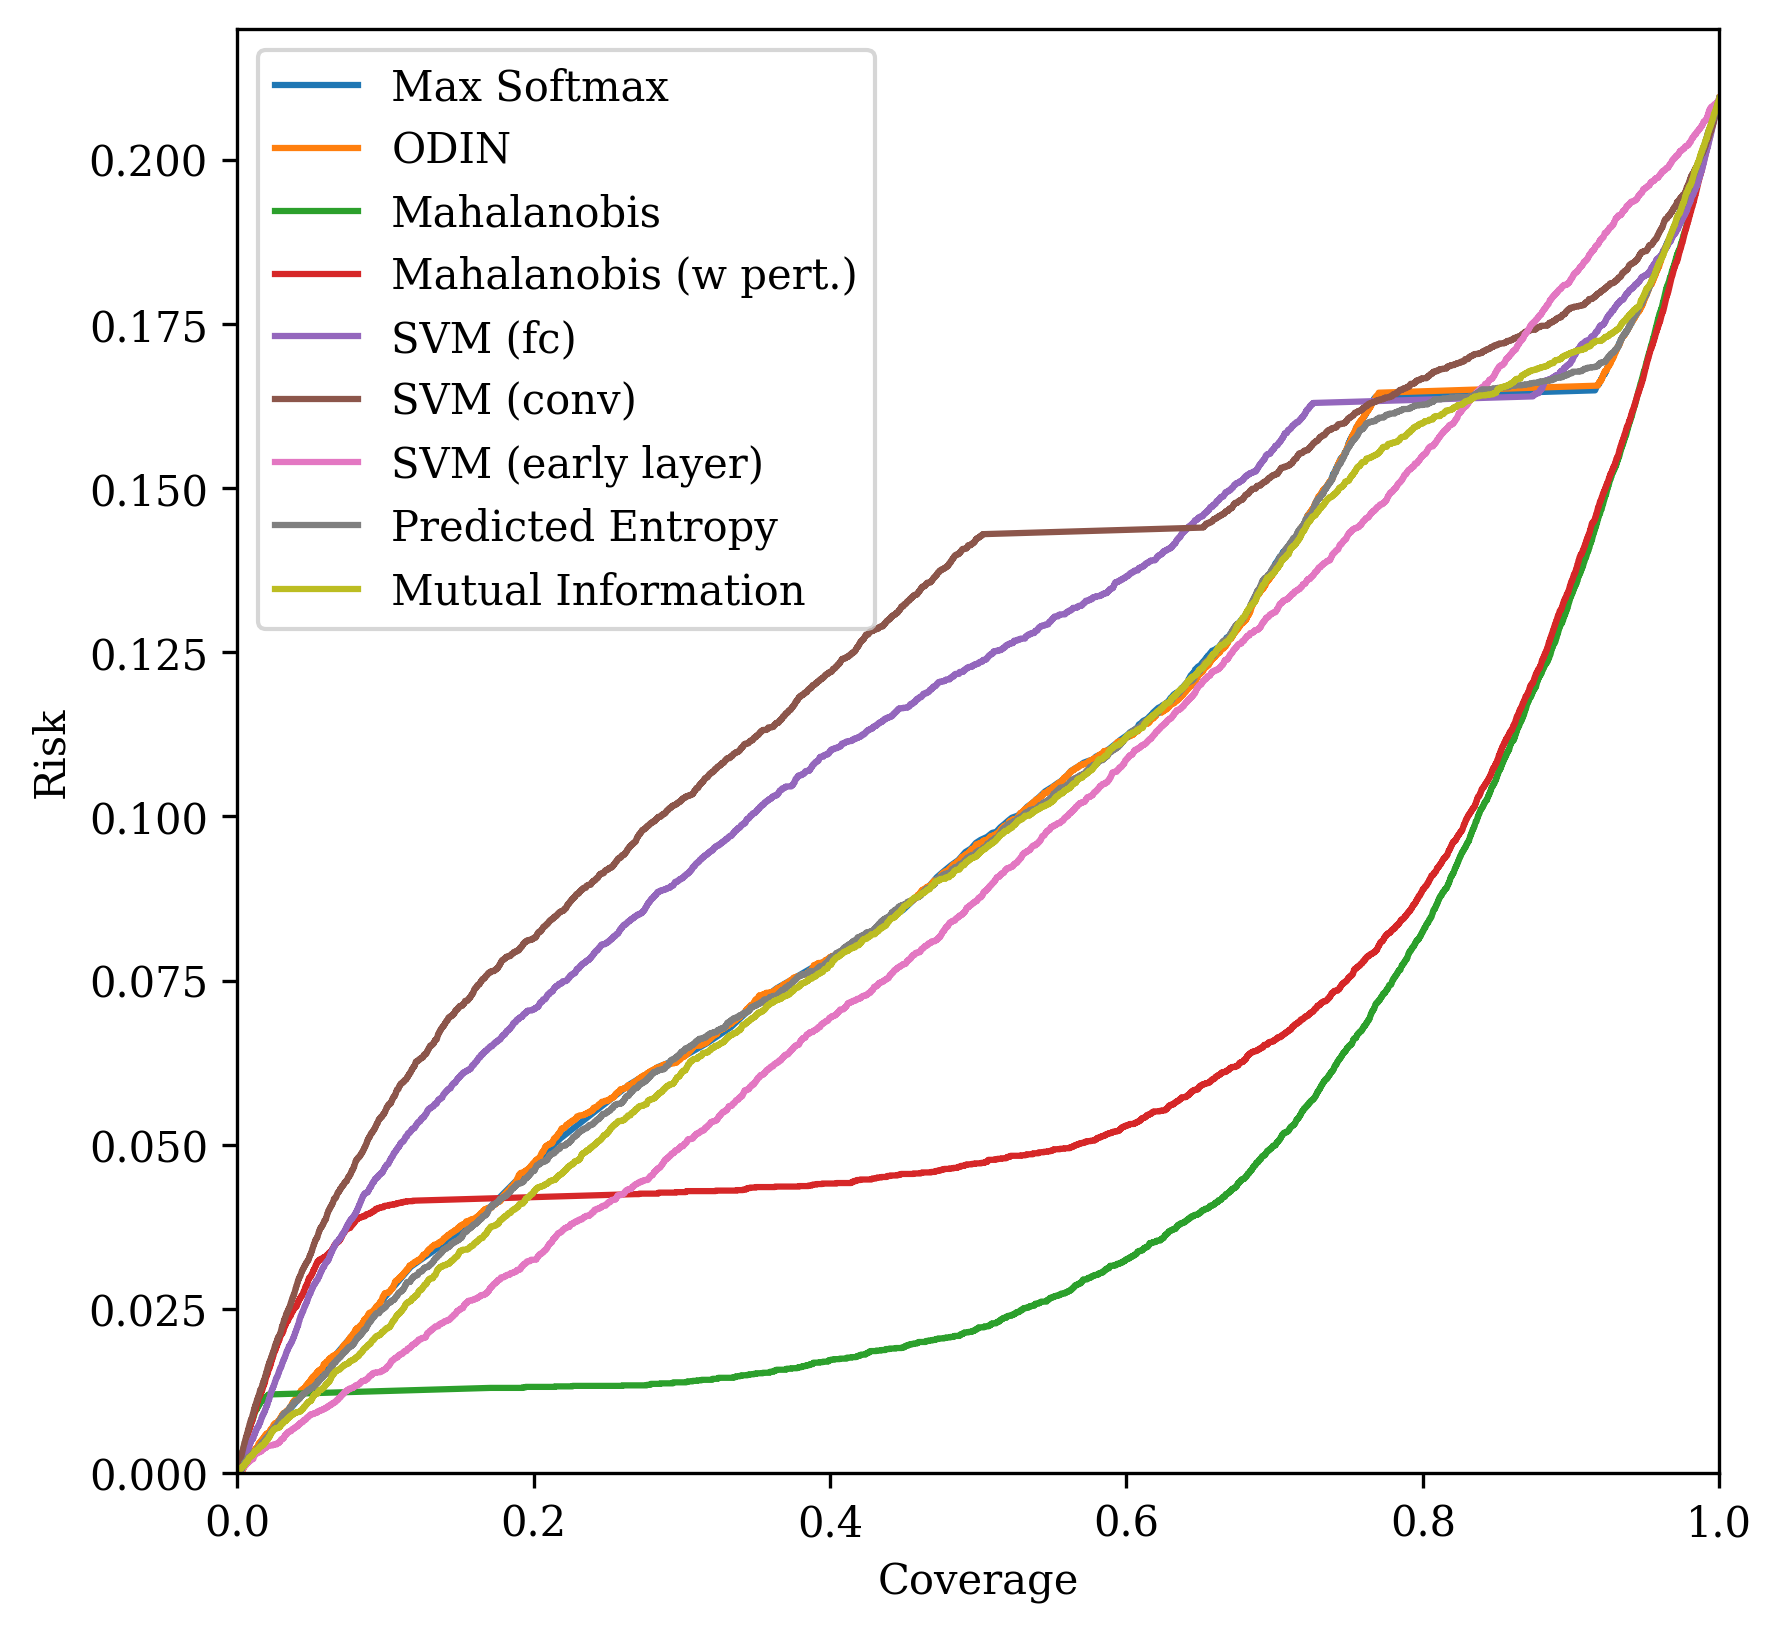

In [62]:
draw_risk_coverage_combined([(*cr, la) for cr, la in zip(kitti_cr, labels)])

### IDD

In [63]:
idd_scores_labels =[load_novelty_scores_labels(
    os.path.join(CHECKPOINT_DIR,"scores_labels_idd_val_%s" % m)) for m in methods]
idd_cr = [risk_coverage(*sl) for sl in idd_scores_labels]

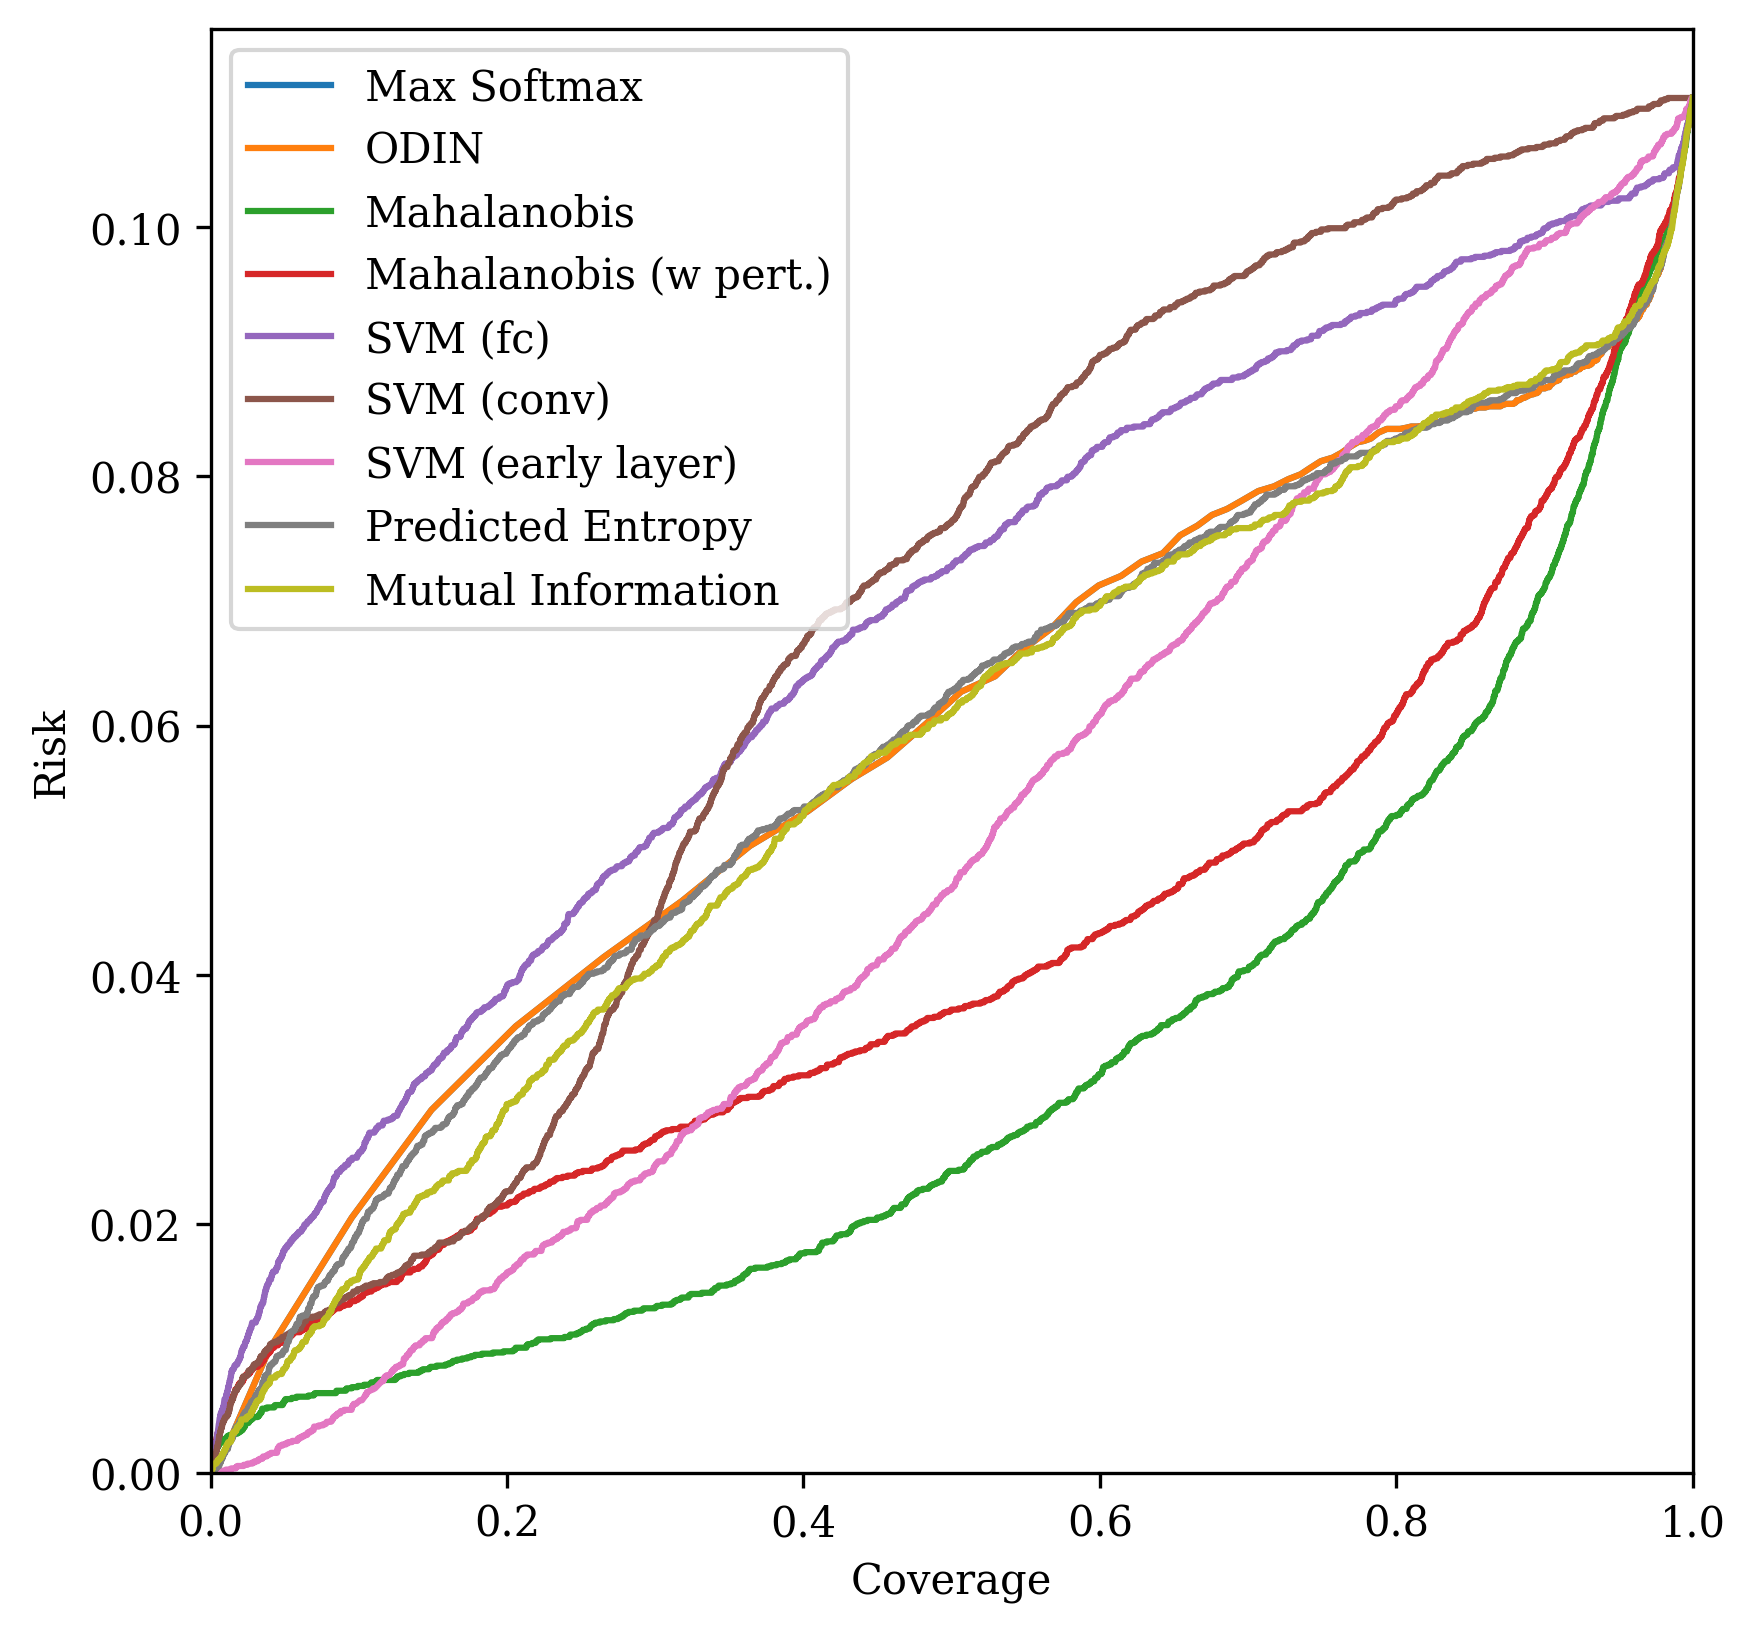

In [64]:
draw_risk_coverage_combined([(*cr, la) for cr, la in zip(idd_cr, labels)])